# Técnicas de balanceo de clases

In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.svm
import matplotlib.pyplot as plt
import imblearn # Bilioteca para aprendizaje desde datos desbalanceados

El problema del desbalance de clases es que la mayoría de las técnicas de aprendizaje de máquinas podrían subrepresentar y hasta ignorar la clase minoritaria, la cual casi siempre es la más importante en nuestra tarea de clasificación y a la cual enfocamos nuestros esfuerzos para mejorar su rendimiento.

## Preparación de los datos

In [2]:
breast_cancer = pd.read_csv("https://raw.githubusercontent.com/fvillena/mlfa/refs/heads/master/data/breast_cancer.csv") # Importamos un conjunto de datos de morfologías celulares y su asociación a malignidad.

In [3]:
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,B,13.540,14.36,87.46,566.3,9.779,8.129,6.664,4.781,1.885,...,15.110,19.26,99.70,711.2,144.000,1.773,239.000,1.288,2.977,7.259
1,B,13.080,15.71,85.63,520.0,1.075,127.000,4.568,311.000,1.967,...,14.500,20.49,96.09,630.5,1.312,2.776,189.000,7.283,3.184,8.183
2,B,9.504,12.44,60.34,273.9,1.024,6.492,2.956,2.076,1.815,...,10.230,15.66,65.13,314.9,1.324,1.148,8.867,6.227,245.000,7.773
3,B,13.030,18.42,82.61,523.8,8.983,3.766,2.562,2.923,1.467,...,13.300,22.81,84.46,545.9,9.701,4.619,4.833,5.013,1.987,6.169
4,B,8.196,16.84,51.71,201.9,86.000,5.943,1.588,5.917,1.769,...,8.964,21.96,57.26,242.2,1.297,1.357,688.000,2.564,3.105,7.409


La columna diagnosis incluye la etiqueta asociada a esa observación.

In [4]:
breast_cancer.diagnosis.value_counts( # Exploremos el balance de las clases del conjunto de dato
    normalize = True # Normalizamos el resultado para obtener la proporción de las clases.
)

diagnosis
B    0.922481
M    0.077519
Name: proportion, dtype: float64

Sólo el 8 % de las observaciones pertenece a la clase M (Maligno)

In [5]:
features = breast_cancer.iloc[:,1:] # Seleccionamos sólo las características y las guardamos en una variable.
feature_names = features.columns # Guardamos los nombres de las características
label = breast_cancer.diagnosis # La columna diagnosis contiene la etiqueta de los datos

In [6]:
feature_names

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

Primero verificamos los rangos de las variables.

In [7]:
features.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,...,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,12.469481,18.113747,80.410465,492.932041,49.744455,35.652729,43.771661,32.595760,21.960455,64.511034,...,13.920488,23.914651,90.925168,618.007752,13.864899,33.948514,39.414204,54.998109,27.036059,59.537822
std,2.176057,4.041660,14.754203,183.335352,187.941745,135.979181,150.341273,104.720222,58.314459,182.662695,...,2.871213,5.693853,20.076597,295.328421,60.586437,115.481235,133.193922,179.546410,78.141293,195.397602
min,6.981000,9.710000,43.790000,143.500000,0.110000,0.060000,0.000000,0.000000,0.180000,5.185000,...,7.930000,12.020000,50.410000,185.200000,0.130000,0.100000,0.000000,0.000000,0.210000,0.120000
25%,11.220000,15.195000,71.490000,386.050000,1.230500,1.997000,2.038000,1.931500,1.597000,5.883000,...,12.320000,19.655000,79.375000,458.000000,1.202500,1.665500,1.606500,1.617000,2.445500,6.774500
50%,12.340000,17.570000,78.850000,466.100000,8.306000,5.688000,3.735000,2.924000,1.769000,6.246000,...,13.580000,23.070000,88.100000,562.600000,1.338000,2.399000,2.671000,5.602000,2.768000,7.628000
75%,13.645000,20.200000,87.860000,572.050000,9.264000,7.815500,6.539500,5.548000,1.998000,6.907500,...,15.105000,27.260000,98.955000,700.650000,1.546000,5.805500,6.237000,8.249000,3.159000,8.472500
max,21.160000,33.810000,137.200000,1404.000000,997.000000,958.000000,973.000000,917.000000,304.000000,898.000000,...,29.170000,41.780000,188.000000,2615.000000,997.000000,937.000000,942.000000,991.000000,353.000000,997.000000


Procedemos a escalar los datos porque las características tienen distintos rangos.

In [8]:
scaler = sklearn.preprocessing.MinMaxScaler() 
features = pd.DataFrame(scaler.fit_transform(features), columns=feature_names)

Ahora todas las características se encuentran en el rango entre 0 y 1.

In [9]:
features.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,...,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,0.387085,0.348703,0.392040,0.277217,0.049789,0.037155,0.044986,0.035546,0.071689,0.066448,...,0.282038,0.399686,0.294463,0.178125,0.013778,0.036128,0.041841,0.055498,0.076040,0.059604
std,0.153470,0.167704,0.157951,0.145447,0.188528,0.141950,0.154513,0.114199,0.191938,0.204592,...,0.135180,0.191326,0.145916,0.121544,0.060777,0.123259,0.141395,0.181177,0.221495,0.196009
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.298963,0.227593,0.296542,0.192424,0.001124,0.002022,0.002095,0.002106,0.004664,0.000782,...,0.206685,0.256552,0.210517,0.112273,0.001076,0.001671,0.001705,0.001632,0.006337,0.006675
50%,0.377953,0.326141,0.375335,0.255930,0.008222,0.005875,0.003839,0.003189,0.005230,0.001188,...,0.266008,0.371304,0.273930,0.155321,0.001212,0.002454,0.002835,0.005653,0.007251,0.007531
75%,0.469991,0.435270,0.471791,0.339984,0.009183,0.008096,0.006721,0.006050,0.005984,0.001929,...,0.337806,0.512097,0.352824,0.212137,0.001420,0.006090,0.006621,0.008324,0.008359,0.008379
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split(
    features,
    label,
    test_size=0.30, 
    random_state = 11,
    stratify = label
)

Para explorar los datos construiremos un gráfico de dispersión con un par de variables y la etiqueta correspondiente de la observación.

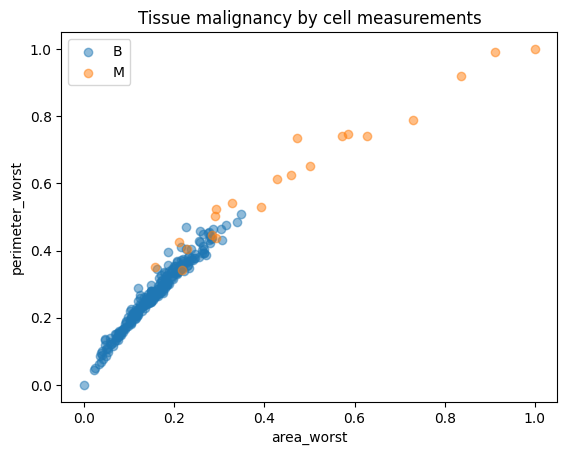

In [11]:
plt.scatter(features_train[label_train == "B"].area_worst, 
            features_train[label_train == "B"].perimeter_worst, 
            label="B",
            alpha=0.5
           )
plt.scatter(features_train[label_train == "M"].area_worst, 
            features_train[label_train == "M"].perimeter_worst, 
            label="M",
            alpha=0.5
           )
plt.title("Tissue malignancy by cell measurements")
plt.xlabel("area_worst")
plt.ylabel("perimeter_worst")
plt.legend()
plt.show()

En el gráfico anterior se puede observar claramente el desbalance de las clases, donde la clase M está sumamente subrepresentada en el conjunto de datos.

Observemos primero las medidas de tendencia central que tienen las características de la clase M.

In [12]:
features_train[label_train == "M"].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.663486,0.439123,0.692003,0.573061,0.141615,0.010819,0.062898,0.057599,0.073993,0.038804,...,0.580890,0.543859,0.622038,0.467213,0.007940,0.030168,0.031266,0.058382,0.046244,0.013335
std,0.217471,0.126019,0.212234,0.256124,0.344882,0.028494,0.197477,0.216554,0.215491,0.153229,...,0.201722,0.185848,0.199145,0.241883,0.030101,0.084298,0.123956,0.092937,0.167898,0.036844
min,0.313069,0.188797,0.361739,0.192463,0.000896,0.000983,0.001127,0.001137,0.004615,0.000104,...,0.328625,0.156250,0.343339,0.157420,0.000910,0.000171,0.000425,0.001129,0.006040,0.000906
25%,0.475986,0.373029,0.533241,0.344942,0.001014,0.001286,0.001567,0.005735,0.005312,0.000624,...,0.419492,0.486559,0.447634,0.289530,0.001248,0.002153,0.002843,0.001640,0.007404,0.001286
50%,0.625503,0.461411,0.641366,0.507100,0.001319,0.001655,0.002187,0.008431,0.005974,0.001080,...,0.568738,0.540995,0.614071,0.428760,0.001338,0.004059,0.004017,0.002228,0.009598,0.007429
75%,0.859652,0.516183,0.922920,0.777073,0.009751,0.002439,0.010149,0.009578,0.006981,0.002797,...,0.703861,0.633737,0.741987,0.584739,0.001529,0.006248,0.005880,0.150353,0.011780,0.008274
max,1.000000,0.626141,1.000000,1.000000,0.976928,0.113723,0.893114,1.000000,0.772892,0.703186,...,1.000000,0.963038,1.000000,1.000000,0.139306,0.336108,0.572187,0.245207,0.778905,0.173421


## Clases desbalanceadas

Entrenemos un modelo con las clases desbalanceadas.

In [13]:
lr = sklearn.linear_model.LogisticRegression(random_state=11)
lr.fit(features_train, label_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,11
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [14]:
lr_predictions = lr.predict(features_test)

In [15]:
print(sklearn.metrics.classification_report(label_test, lr_predictions))

              precision    recall  f1-score   support

           B       0.96      1.00      0.98       108
           M       1.00      0.56      0.71         9

    accuracy                           0.97       117
   macro avg       0.98      0.78      0.85       117
weighted avg       0.97      0.97      0.96       117



La métrica que salta a la luz es el bajo recall de la clase M.

## Submuestreo de la clase mayoritaria

El enfoque más ingenuo para corregir el balance de los datos sería utilizar sólo un subconjunto de la clase sobrerepresentada que tenga el mismo tamaño que la clase subrepresentada.

Los métodos utilizados para remuestrear las clases se encuentran en la biblioteca imblearn. La técnica enunciada anteriormente se encuentra en la clase imblearn.under_sampling.RandomUnderSampler(). Esta clase implementa métodos para submuestrar al azar la clase mayoritaria para igualar su frecuencia a la de la clase minoritaria.

In [16]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state=11) # Instanciamos la clase para submuestrear nuestro conjunto de datos.
features_train_rus, label_train_rus = rus.fit_resample(features_train, label_train) # Con este método remuestreamos 
                                                                                    # las características y la etiqueta 
                                                                                    # y las guardamos en variables

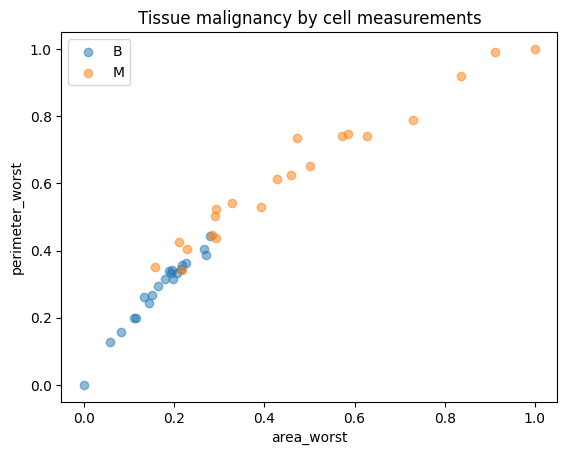

In [17]:
plt.scatter(features_train_rus[label_train_rus == "B"].area_worst, 
            features_train_rus[label_train_rus == "B"].perimeter_worst, 
            label="B",
            alpha=0.5
           )
plt.scatter(features_train_rus[label_train_rus == "M"].area_worst, 
            features_train_rus[label_train_rus == "M"].perimeter_worst, 
            label="M",
            alpha=0.5
           )
plt.title("Tissue malignancy by cell measurements")
plt.xlabel("area_worst")
plt.ylabel("perimeter_worst")
plt.legend()
plt.show()

El gráfico nos comunica que sí hay un balance en las clases del conjunto de datos, pero hay significativamente menos datos para entrenar.

In [18]:
lr = sklearn.linear_model.LogisticRegression(random_state=11)
lr.fit(features_train_rus, label_train_rus)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,11
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [19]:
lr_predictions = lr.predict(features_test)

In [20]:
print(sklearn.metrics.classification_report(label_test, lr_predictions))

              precision    recall  f1-score   support

           B       0.99      0.97      0.98       108
           M       0.73      0.89      0.80         9

    accuracy                           0.97       117
   macro avg       0.86      0.93      0.89       117
weighted avg       0.97      0.97      0.97       117



Logramos aumentar el recall de la clase M a a costa de disminuir la precisión, pero nuestras métricas en general aumentaron.

## Sobremuestreo de la clase minoritaria

Otro enfoque simple para resolver el desbalance de las clases es remuestrar la clase minoritaria al multiplicar observaciones de esa clase de manera aleatoria hasta alcanzar la frecuencia de la clase mayoritaria.

Esta técnica está implementada en la clase imblearn.over_sampling.RandomOverSampler().

In [21]:
ros = imblearn.over_sampling.RandomOverSampler(random_state=11) # Instanciamos la clase para sobremuestrear nuestro conjunto de datos.
features_train_ros, label_train_ros = ros.fit_resample(features_train, label_train)

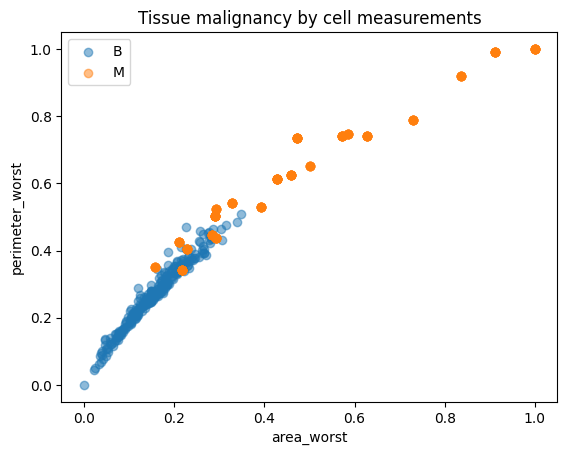

In [22]:
plt.scatter(features_train_ros[label_train_ros == "B"].area_worst, 
            features_train_ros[label_train_ros == "B"].perimeter_worst, 
            label="B",
            alpha=0.5
           )
plt.scatter(features_train_ros[label_train_ros == "M"].area_worst, 
            features_train_ros[label_train_ros == "M"].perimeter_worst, 
            label="M",
            alpha=0.5
           )
plt.title("Tissue malignancy by cell measurements")
plt.xlabel("area_worst")
plt.ylabel("perimeter_worst")
plt.legend()
plt.show()

Se evidencia que tenemos una cantidad significativa de datos, pero la clase minoritaria fue aumentada sólo a costa de exactamente los mismos datos de la clase.

In [23]:
lr = sklearn.linear_model.LogisticRegression(random_state=11)
lr.fit(features_train_ros, label_train_ros)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,11
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [24]:
lr_predictions = lr.predict(features_test)

In [25]:
print(sklearn.metrics.classification_report(label_test, lr_predictions))

              precision    recall  f1-score   support

           B       1.00      0.96      0.98       108
           M       0.69      1.00      0.82         9

    accuracy                           0.97       117
   macro avg       0.85      0.98      0.90       117
weighted avg       0.98      0.97      0.97       117



Aumentamos el recall de la clase M y aumentamos las métricas generales del experimento. Este método al parecer es mejor que el anterior, porque en ese se pierde mucha información al eliminar datos.

## _Synthetic Minority Oversampling Technique_

El sobremuestreo al azar no agrega información nueva al conjunto de datos. La técnica que exploraremos ahora sintetiza nuevos datos desde las observaciones con las que cuenta el conjunto de datos.

SMOTE crea nuevas observaciones al trazar lineas entre observaciones de la clase minoritaria y agrega al azar una observación sobre esa línea.

Esté método está implementado en la clase imblearn.over_sampling.SMOTE()

In [26]:
sm = imblearn.over_sampling.SMOTE(random_state=11)
features_train_smote, label_train_smote = sm.fit_resample(features_train, label_train)

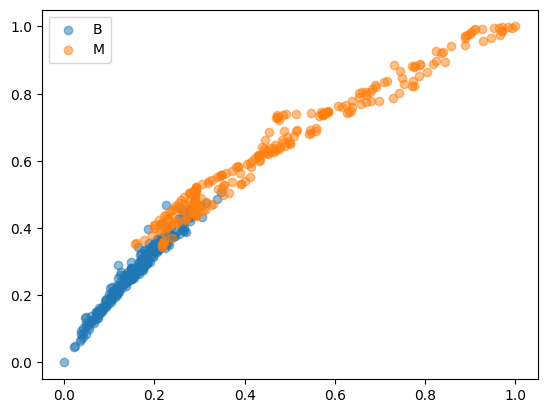

In [27]:
plt.scatter(features_train_smote[label_train_smote == "B"].area_worst, 
            features_train_smote[label_train_smote == "B"].perimeter_worst, 
            label="B",
            alpha=0.5
           )
plt.scatter(features_train_smote[label_train_smote == "M"].area_worst, 
            features_train_smote[label_train_smote == "M"].perimeter_worst, 
            label="M",
            alpha=0.5
           )
plt.legend()
plt.show()

Tenemos un conjunto de datos balanceados y las observaciones sintetizadas siguen la silueta del espacio original.

In [28]:
features_train_ros[label_train_smote == "M"].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,...,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,0.667711,0.435546,0.696743,0.578279,0.147886,0.009209,0.055266,0.045299,0.082338,0.032053,...,0.581314,0.541189,0.624648,0.468427,0.007446,0.033393,0.029157,0.058714,0.040365,0.009861
std,0.215136,0.132995,0.212213,0.252425,0.344231,0.025292,0.179230,0.185791,0.220165,0.131703,...,0.195194,0.195923,0.193755,0.233539,0.028406,0.086725,0.116995,0.092291,0.151395,0.028081
min,0.313069,0.188797,0.361739,0.192463,0.000896,0.000983,0.001127,0.001137,0.004615,0.000104,...,0.328625,0.156250,0.343339,0.157420,0.000910,0.000171,0.000425,0.001129,0.006040,0.000906
25%,0.475986,0.339419,0.533241,0.344942,0.001014,0.001145,0.001567,0.005651,0.005312,0.000624,...,0.419492,0.453965,0.447634,0.289530,0.001212,0.002153,0.002642,0.001624,0.007367,0.001286
50%,0.625503,0.461411,0.641366,0.507100,0.001319,0.001607,0.002187,0.008431,0.005974,0.001080,...,0.568738,0.540995,0.614071,0.428760,0.001318,0.004059,0.003863,0.002114,0.009598,0.007429
75%,0.859652,0.535270,0.922920,0.777073,0.009767,0.002439,0.010149,0.009413,0.006981,0.002928,...,0.703861,0.633737,0.741987,0.584739,0.001529,0.006248,0.005880,0.182644,0.011780,0.008121
max,1.000000,0.626141,1.000000,1.000000,0.976928,0.113723,0.893114,1.000000,0.772892,0.703186,...,1.000000,0.963038,1.000000,1.000000,0.139306,0.336108,0.572187,0.245207,0.778905,0.173421


Al revisar las medidas de tendencia central podemos darnos cuenta que no cambian respecto a las originales.

In [29]:
lr = sklearn.linear_model.LogisticRegression(random_state=11)
lr.fit(features_train_smote, label_train_smote)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,11
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [30]:
lr_predictions = lr.predict(features_test)

In [31]:
print(sklearn.metrics.classification_report(label_test, lr_predictions))

              precision    recall  f1-score   support

           B       0.99      0.96      0.98       108
           M       0.67      0.89      0.76         9

    accuracy                           0.96       117
   macro avg       0.83      0.93      0.87       117
weighted avg       0.97      0.96      0.96       117



Con esta técnica, obtenermos resultados similares con el sobremuestreo de la clase minoritaria.

## _Synthetic Minority Oversampling Technique_ + Submuestro de la clase mayoritaria + Balanceo parcial del conjunto de datos

Los autores de SMOTE recomiendan realizar paralelamente un submuestreo de la clase mayoritaria para poder obtener mejores resultados

In [32]:
sm = imblearn.over_sampling.SMOTE(sampling_strategy=0.3,random_state=11) # Hacemos SMOTe hasta obtener un balance de 30% de la clase minoritaria
rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5,random_state=11) # Hacemos submuestreo hasta obtener un balance del 50%
steps = [('SMOTE', sm), ('RUS', rus)] # Ponemos ambos pasos
sm_rus = imblearn.pipeline.Pipeline(steps=steps) # Creamos un pipeline para realizar ambas tareas
features_train_sm_rus, label_train_sm_rus = sm_rus.fit_resample(features_train, label_train)

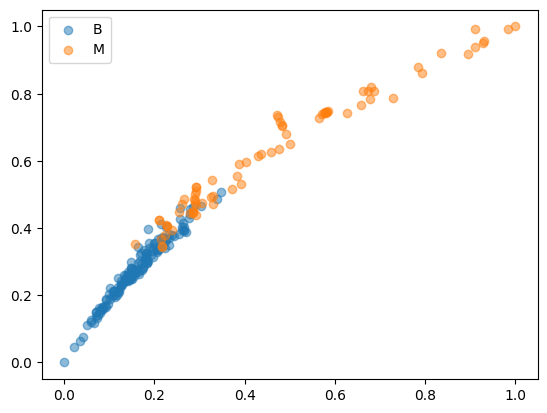

In [33]:
plt.scatter(features_train_sm_rus[label_train_sm_rus == "B"].area_worst, 
            features_train_sm_rus[label_train_sm_rus == "B"].perimeter_worst, 
            label="B",
            alpha=0.5
           )
plt.scatter(features_train_sm_rus[label_train_sm_rus == "M"].area_worst, 
            features_train_sm_rus[label_train_sm_rus == "M"].perimeter_worst, 
            label="M",
            alpha=0.5
           )
plt.legend()
plt.show()

In [34]:
lr = sklearn.linear_model.LogisticRegression(random_state=11)
lr.fit(features_train_sm_rus, label_train_sm_rus)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,11
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [35]:
lr_predictions = lr.predict(features_test)

In [36]:
print(sklearn.metrics.classification_report(label_test, lr_predictions))

              precision    recall  f1-score   support

           B       0.99      0.98      0.99       108
           M       0.80      0.89      0.84         9

    accuracy                           0.97       117
   macro avg       0.90      0.94      0.91       117
weighted avg       0.98      0.97      0.97       117



Pudimos mejorar las métricas y esta técnica es la que mejor se comporta